# **HW5: Autoencoders**

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version of it. Next, we will experiment with the application of a denoising autoencoder. Finally, we will experiment with sequential domains, considering the IMDB dataset, alredy used in HW4.

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
Each value is between 0 and 255, and represents a pixel in an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, we will split the test set, in the test and validation set.

In [0]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW we will focus our attention on SVD decomposition. Indeed it is more numerical stable. Given a matrix X, the SVD decomposes a matrix into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T$$

SVD is implemented in NumPy as np.linalg.svd. In our case the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that the X matrix, in our case, will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore, to optimize the memory consumption we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we can relate the decomposition of the covariance matrix $C= X^T \cdot X$ to the decomposition of $X$. In fact

$$ C= X^T \cdot X = U \cdot S \cdot V^T \cdot V\cdot S \cdot U^T  = U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the Colab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [0]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data, and compute the compressed version of the training set and the test set.

**To complete: What happens varying the ENCODING_DIM? test  and discuss the results in this cell**

After some tests, when I improve ENCODING_DIM there is less information loss, so when I reconstruct the images they appear more similar than original images.
If I reduce ENCODING_DIM (ENCODING_DIM = 50) there is a stronger compression so I loose information and the reconstruction appears worst and the numbers are blurred.

In [0]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)

Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images

In [0]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)




In [0]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [0]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed, by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images shows input data, while the second one shows the reconstructions.

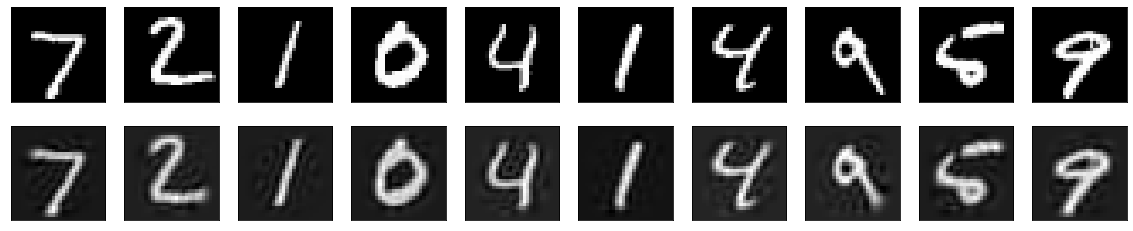

In [0]:
plot_img(10, x_test, x_test_reco)

## Exercise 5.1: Shallow Linear Autoencoder
Let's define the model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various parts of the model (encoder and decoder) separately and create the final model. 

**To complete: check the results and compare them with the results obtained by SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.**




In [0]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [0]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [0]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0434 - val_loss: 0.0143
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0087
Epoch 3/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 4/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 5/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 6/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 7/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 8/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 9/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 10/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 11/15
98/98 [

Plot the loss and the accuracy curves, and the accuracy on the test set.

In [0]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00478


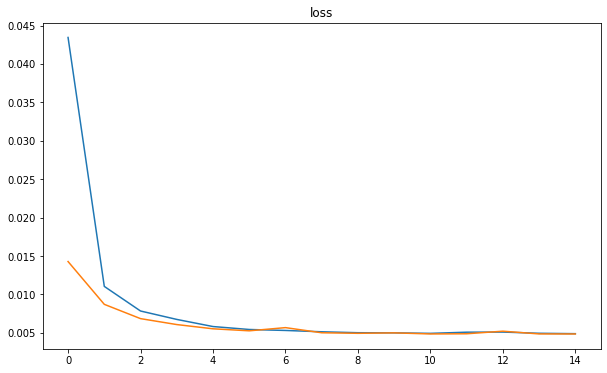

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

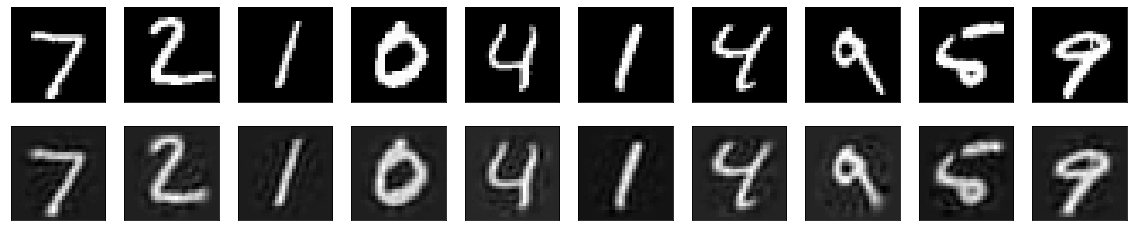

In [0]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


The results are similar to the Single Value Decomposition, due to the fact that an autoencoder without non-linearity it's very similar to PCA.
In the case of similar performace I think SVD is better because is computationally cheaper.

##Exercise  5.2: Shallow non-linear autoencoders

**To complete: replicate the code of exercise 5.1 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1.**

I tried to choose the non-linear functions that minimizes the mean squared error.
I achieved the best performance using softplus function.
Now, there's more sharpness on the reconstructed images and and black parts are more uniform.
However the MSE is greater than the linear autoencoder if I train this autoencoder only 15 epochs. The situation change and MSE decrease if I train  this this network increasing epochs (e. g. 50)

My original idea was to use sigmoid function on the output layer because pixels are values between 0 and 1 but in this case performance didn't increase. Probably because of the other hyperparameters like learning rate, epochs and batch_size. This exercise asked me to change only the activation functions so I didn't change other hyperparameters.


Epoch 1/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0555 - val_loss: 0.0256
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0198 - val_loss: 0.0162
Epoch 3/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 4/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 5/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 6/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 7/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 8/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 9/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 10/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 11/15
98/98 [

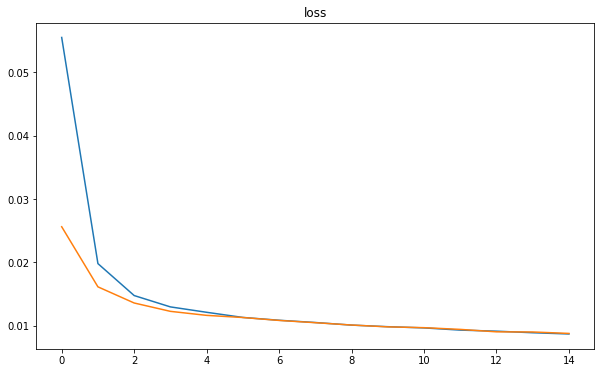

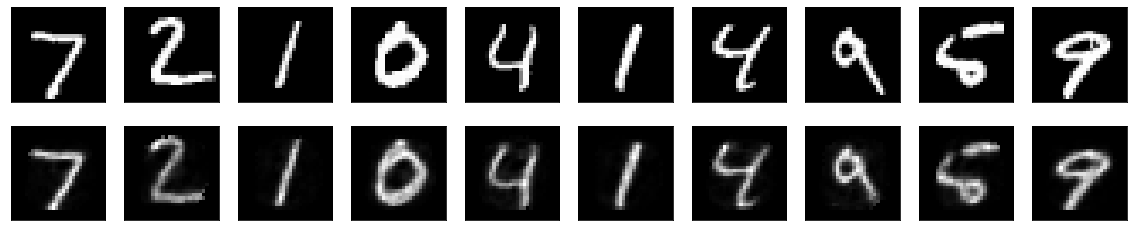

In [0]:
input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='softplus')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='softplus')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                    loss='mse')



history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, 
                          shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))


encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

## Exercise 5.3: Deep Autoencoder
**To_complete: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (e.g., 748->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e, 128->748, the resulting structure recall an hourglass).
Similarly than what did above, print the model summary, the loss curve during the training, the achieved loss on the test set, and some input image with the correspondent decoding.**


In [0]:
ENCODING_DIM = 64

input_img = tf.keras.layers.Input(shape=(784,))

encoded_1 = tf.keras.layers.Dense(512, activation='softplus')(input_img)
encoded_2 = tf.keras.layers.Dense(256, activation='softplus')(encoded_1)
encoded_3 = tf.keras.layers.Dense(128, activation='softplus')(encoded_2)
encoded_4 = tf.keras.layers.Dense(ENCODING_DIM, activation='softplus')(encoded_2)

decoded_1 = tf.keras.layers.Dense(128, activation='softplus')(encoded_3)
decoded_2 = tf.keras.layers.Dense(256, activation='softplus')(decoded_1)
decoded_3 = tf.keras.layers.Dense(784, activation='sigmoid')(decoded_2)

autoencoder = tf.keras.models.Model(input_img, decoded_3)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='mse')

In [0]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               2014

In [0]:
history = autoencoder.fit(x_train, x_train, epochs=500, batch_size=256, 
                          shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/500
196/196 [==============================] - 1s 5ms/step - loss: 0.0936 - val_loss: 0.0629
Epoch 2/500
196/196 [==============================] - 1s 3ms/step - loss: 0.0507 - val_loss: 0.0390
Epoch 3/500
196/196 [==============================] - 1s 3ms/step - loss: 0.0342 - val_loss: 0.0298
Epoch 4/500
196/196 [==============================] - 1s 3ms/step - loss: 0.0278 - val_loss: 0.0254
Epoch 5/500
196/196 [==============================] - 1s 4ms/step - loss: 0.0242 - val_loss: 0.0224
Epoch 6/500
196/196 [==============================] - 1s 3ms/step - loss: 0.0215 - val_loss: 0.0202
Epoch 7/500
196/196 [==============================] - 1s 4ms/step - loss: 0.0195 - val_loss: 0.0184
Epoch 8/500
196/196 [==============================] - 1s 4ms/step - loss: 0.0179 - val_loss: 0.0170
Epoch 9/500
196/196 [==============================] - 1s 4ms/step - loss: 0.0167 - val_loss: 0.0159
Epoch 10/500
196/196 [==============================] - 1s 3ms/step - loss: 0.0156 - val_lo

313/313 - 0s - loss: 0.0019
test mse: 0.00190


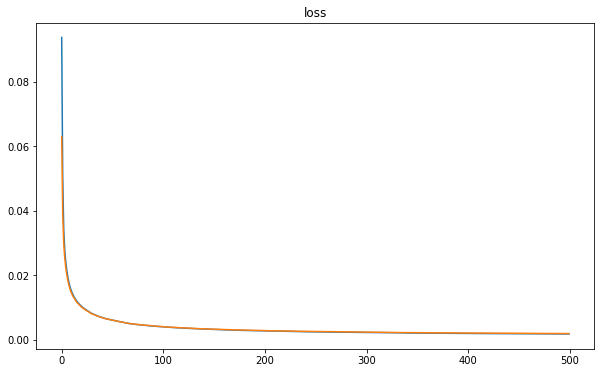

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

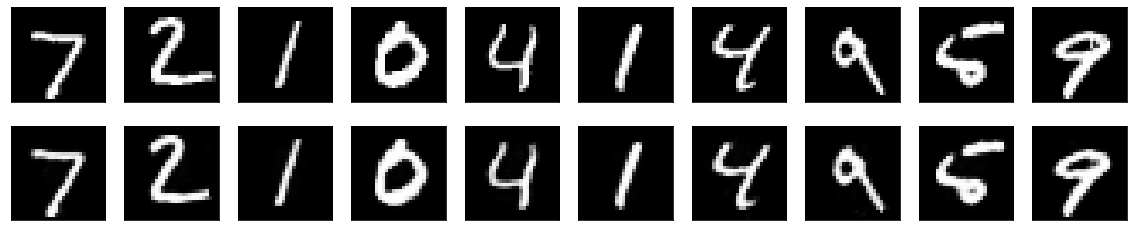

In [0]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## Exercise 5.4: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data, and to check how much it influences the denoising capability of the autoencoder.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

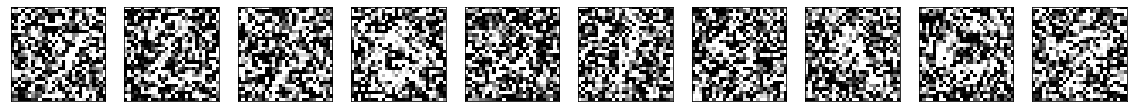

In [0]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**To_complete: use the same model defined in the exercise 5.3.**

In [0]:
ENCODING_DIM = 64

input_img = tf.keras.layers.Input(shape=(784,))

encoded_1 = tf.keras.layers.Dense(512, activation='softplus')(input_img)
encoded_2 = tf.keras.layers.Dense(256, activation='softplus')(encoded_1)
encoded_3 = tf.keras.layers.Dense(128, activation='softplus')(encoded_2)
encoded_4 = tf.keras.layers.Dense(ENCODING_DIM, activation='softplus')(encoded_2)

decoded_1 = tf.keras.layers.Dense(128, activation='softplus')(encoded_3)
decoded_2 = tf.keras.layers.Dense(256, activation='softplus')(decoded_1)
decoded_3 = tf.keras.layers.Dense(784, activation='sigmoid')(decoded_2)

autoencoder = tf.keras.models.Model(input_img, decoded_3)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='mse')

In [0]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_17 (Dense)             (None, 784)               2014

**To complete: Train the model by passing the noisy input and the clean target.**

In [0]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=200, batch_size=256, 
                          shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/200
196/196 [==============================] - 1s 4ms/step - loss: 0.0961 - val_loss: 0.0678
Epoch 2/200
196/196 [==============================] - 1s 3ms/step - loss: 0.0667 - val_loss: 0.0641
Epoch 3/200
196/196 [==============================] - 1s 3ms/step - loss: 0.0596 - val_loss: 0.0554
Epoch 4/200
196/196 [==============================] - 1s 3ms/step - loss: 0.0531 - val_loss: 0.0506
Epoch 5/200
196/196 [==============================] - 1s 3ms/step - loss: 0.0493 - val_loss: 0.0478
Epoch 6/200
196/196 [==============================] - 1s 3ms/step - loss: 0.0473 - val_loss: 0.0466
Epoch 7/200
196/196 [==============================] - 1s 4ms/step - loss: 0.0461 - val_loss: 0.0454
Epoch 8/200
196/196 [==============================] - 1s 3ms/step - loss: 0.0452 - val_loss: 0.0445
Epoch 9/200
196/196 [==============================] - 1s 3ms/step - loss: 0.0443 - val_loss: 0.0437
Epoch 10/200
196/196 [==============================] - 1s 3ms/step - loss: 0.0434 - val_lo

313/313 - 0s - loss: 0.0302
test mse: 0.03018


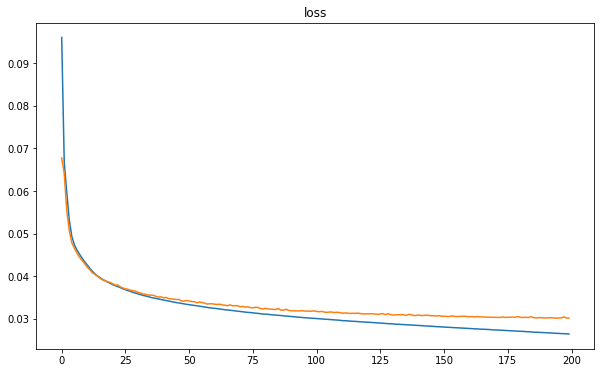

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

Check the result by plotting some input images and the correspondent denoised outputs

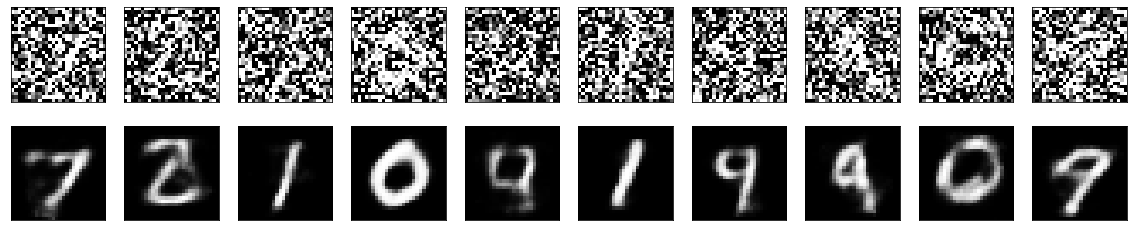

In [0]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [0]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



1646592/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by the IMDB dataset loader, we use the to_categorical method to transform them in the correspondent one-hot representations.

In [0]:
from keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in exercise 5.1, while the encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense layer on each time step of the sequence. 

Since the output will be a one-hot representation, let's use the binary_crossentropy as loss and the CategoricalAccuracy as metric.

In [0]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 4s 55ms/step - loss: 0.1614 - categorical_accuracy: 0.1893 - val_loss: 0.0751 - val_categorical_accuracy: 0.3787
Epoch 2/50
79/79 [==============================] - 4s 54ms/step - loss: 0.0658 - categorical_accuracy: 0.4692 - val_loss: 0.0614 - val_categorical_accuracy: 0.5055
Epoch 3/50
79/79 [==============================] - 4s 53ms/step - loss: 0.0611 - categorical_accuracy: 0.4872 - val_loss: 0.0561 - val_categorical_accuracy: 0.5264
Epoch 4/50
79/79 [==============================] - 4s 52ms/step - loss: 0.0514 - categorical_accuracy: 0.5437 - val_loss: 0.0485 - val_categorical_accuracy: 0.5440
Epoch 5/50
79/79 [==============================] - 4s 52ms/step - loss: 0.0458 - categorical_accuracy: 0.5698 - val_loss: 0.0438 - val_categorical_accuracy: 0.5678
Epoch 6/50
79/79 [==============================] - 4s 52ms/step - loss: 0.0414 - categorical_accuracy: 0.5764 - val_loss: 0.0406 - val_categorical_accuracy: 0.5825
Epoch 7/50

Let's plot the accuracy and the loss curves and check the reconstruction capability of the model by plotting the reconstruction of a test sample.

40/40 - 0s - loss: 0.0115 - categorical_accuracy: 0.9333
categorical_accuracy: 93.33%


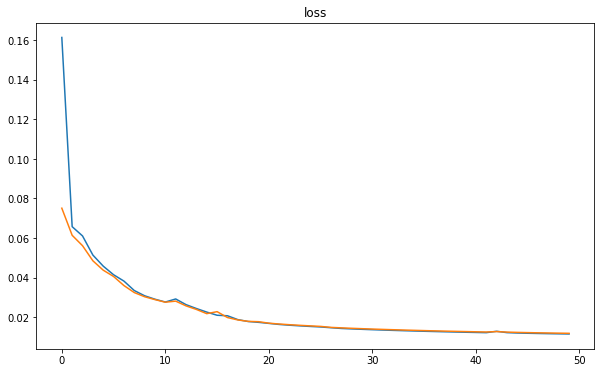

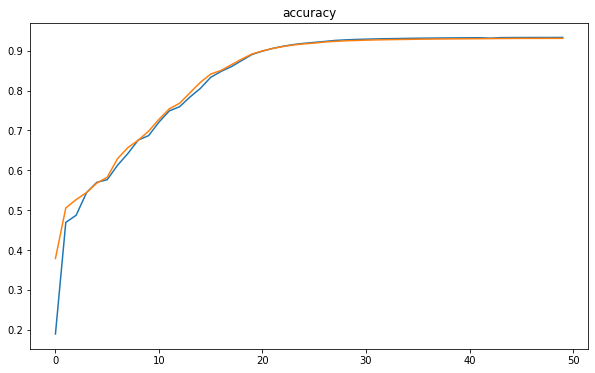

In [0]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [0]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
how a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a <oov> <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> only <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really and film that <oov> <oov> <oov> by have <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> this <oov>


##Exercise 5.5: Non-Linear Autoencoder for sequences

**To complete: Replicate the code of the exercise above, but instead of using a simpleRNN with linear activations do use non-linear activation functions and a LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.**

**Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.**


In [0]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='relu')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='sigmoid'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=80, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/80
79/79 [==============================] - 10s 125ms/step - loss: 0.6164 - categorical_accuracy: 0.1678 - val_loss: 0.5594 - val_categorical_accuracy: 0.4570
Epoch 2/80
79/79 [==============================] - 10s 123ms/step - loss: 0.5118 - categorical_accuracy: 0.4707 - val_loss: 0.4539 - val_categorical_accuracy: 0.4580
Epoch 3/80
79/79 [==============================] - 10s 123ms/step - loss: 0.2463 - categorical_accuracy: 0.2356 - val_loss: 0.1756 - val_categorical_accuracy: 0.1625
Epoch 4/80
79/79 [==============================] - 10s 123ms/step - loss: 0.1688 - categorical_accuracy: 0.1346 - val_loss: 0.1648 - val_categorical_accuracy: 0.1272
Epoch 5/80
79/79 [==============================] - 9s 119ms/step - loss: 0.1637 - categorical_accuracy: 0.1406 - val_loss: 0.1598 - val_categorical_accuracy: 0.1250
Epoch 6/80
79/79 [==============================] - 10s 122ms/step - loss: 0.1597 - categorical_accuracy: 0.1410 - val_loss: 0.1592 - val_categorical_accuracy: 0.1150

40/40 - 0s - loss: 6.6998e-04 - categorical_accuracy: 0.9966
categorical_accuracy: 99.66%


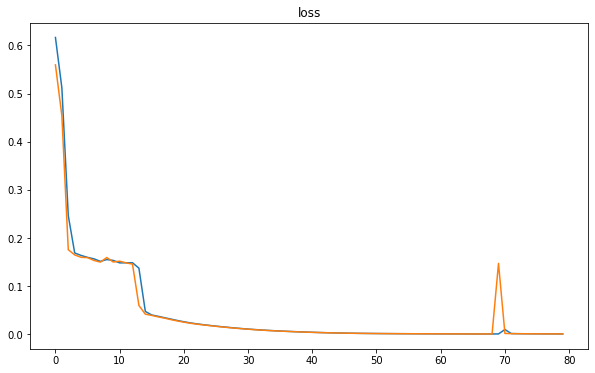

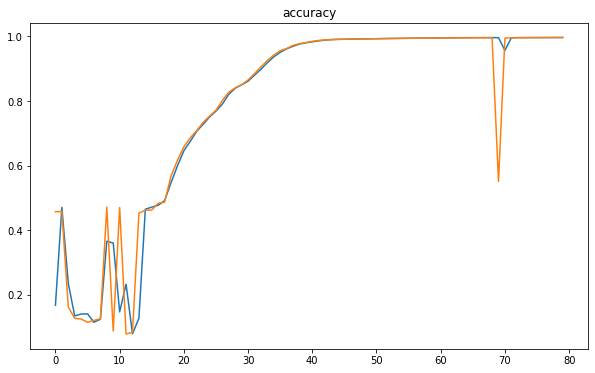

In [0]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [0]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


To achieve my best result in terms of performance I have used LSTM layer with ReLU and sigmoid function for the dense layer.
I have choosen sigmoid because of the one hot encoding applied to the words, so due to the TimeDistribuited layer, the dense layer is applied on every step.
Applying non-linearity to this network allow me to improve the categorical accuracy to 99.66%.